1/500
2/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


3/500
4/500
5/500
6/500
7/500
8/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


9/500
10/500
11/500
12/500
13/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


14/500
15/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


16/500
17/500
18/500
19/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


20/500
21/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


22/500
23/500
24/500
25/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


26/500
27/500
28/500
29/500
30/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


31/500
32/500
33/500
34/500
35/500
36/500
37/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


38/500
39/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


40/500
41/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


42/500
43/500
44/500
45/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


46/500
47/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


48/500
49/500
50/500
51/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


52/500
53/500
54/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


55/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


56/500
57/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


66/500
67/500
68/500
69/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


70/500
71/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


72/500
73/500
74/500
75/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


76/500
77/500
78/500
79/500
80/500
81/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


82/500
83/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


84/500
85/500
86/500
87/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


88/500
89/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


90/500
91/500
92/500
93/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


94/500
95/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


96/500
97/500
98/500
99/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


100/500
101/500
102/500
103/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


104/500
105/500
106/500
107/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


108/500
109/500
110/500
111/500
112/500
113/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


114/500
115/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


116/500
117/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


126/500
127/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


128/500
129/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


130/500
131/500
132/500
133/500
134/500
135/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


136/500
137/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


138/500
139/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


140/500
141/500
142/500
143/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


144/500
145/500
146/500
147/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


148/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


149/500
150/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


151/500
152/500
153/500
154/500
155/500
156/500
157/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


158/500
159/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


160/500
161/500
162/500
163/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


164/500
165/500
166/500
167/500
168/500
169/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


170/500
171/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


172/500
173/500
174/500
175/500
176/500
177/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


178/500
179/500
180/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


181/500
182/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


183/500
184/500
185/500
186/500
187/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


188/500
189/500
190/500
191/500
192/500
193/500
194/500
195/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


196/500
197/500
198/500
199/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


200/500
201/500
202/500
203/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


204/500
205/500
206/500
207/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


208/500
209/500
210/500
211/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


212/500
213/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


214/500
215/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


216/500
217/500
218/500
219/500
220/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


221/500
222/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


223/500
224/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


225/500
226/500
227/500
228/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


229/500
230/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


231/500
232/500
233/500
234/500
235/500
236/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


237/500
238/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


239/500
240/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


241/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


242/500
243/500
244/500
245/500
246/500
247/500
248/500
249/500
250/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


251/500
252/500
253/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


254/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


255/500
256/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


257/500
258/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


259/500
260/500
261/500
262/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


263/500
264/500
265/500
266/500
267/500
268/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


269/500
270/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


271/500
272/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


273/500
274/500
275/500
276/500
277/500
278/500
279/500
280/500
281/500
282/500
283/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


284/500
285/500
286/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


287/500
288/500
289/500
290/500
291/500
292/500
293/500
294/500
295/500
296/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


297/500
298/500
299/500
300/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


301/500
302/500
303/500
304/500
305/500
306/500
307/500
308/500
309/500
310/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


311/500
312/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


313/500
314/500
315/500
316/500
317/500
318/500
319/500
320/500
321/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


322/500
323/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


324/500
325/500
326/500
327/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


328/500
329/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


330/500
331/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


332/500
333/500
334/500
335/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


336/500
337/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


338/500
339/500
340/500
341/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


342/500
343/500
344/500
345/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


346/500
347/500
348/500
349/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


350/500
351/500
352/500
353/500
354/500
355/500
356/500
357/500
358/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


359/500
360/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


361/500
362/500
363/500
364/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


365/500
366/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


367/500
368/500
369/500
370/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


371/500
372/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


373/500
374/500
375/500
376/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


377/500
378/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


379/500
380/500
381/500
382/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


383/500
384/500
385/500
386/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


387/500
388/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


389/500
390/500
391/500
392/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


393/500
394/500
395/500
396/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


397/500
398/500
399/500
400/500
401/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


402/500
403/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


404/500
405/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


406/500
407/500
408/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


409/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


410/500
411/500
412/500
413/500
414/500
415/500
416/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


417/500
418/500
419/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


420/500
421/500
422/500
423/500
424/500
425/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


426/500
427/500
428/500
429/500
430/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


431/500
432/500
433/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


434/500
435/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


436/500
437/500
438/500
439/500
440/500
441/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


442/500
443/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


444/500
445/500
446/500
447/500
448/500
449/500
450/500
451/500
452/500
453/500
454/500
455/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


456/500
457/500
458/500
459/500
460/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


461/500
462/500
463/500
464/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


465/500
466/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


467/500
468/500
469/500
470/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


471/500
472/500
473/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


474/500
475/500
476/500
477/500
478/500
479/500
480/500
481/500
482/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


483/500
484/500
485/500
486/500
487/500
488/500
489/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


490/500
491/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


492/500
493/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


494/500
495/500
496/500
497/500
498/500
499/500
500/500


/home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


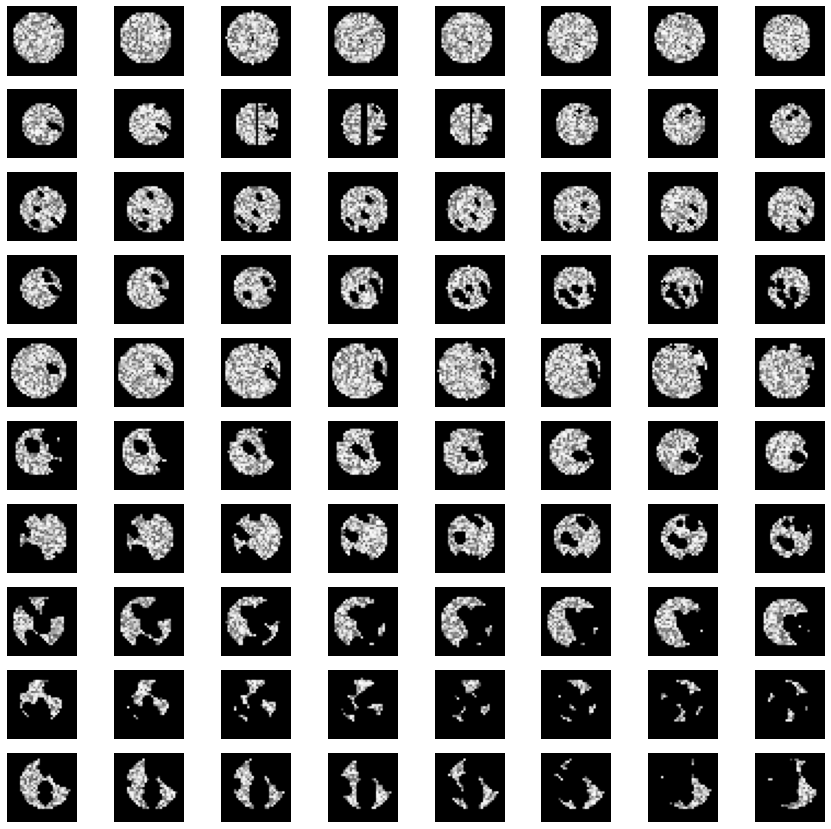

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances


IMAGE_SIZE = 32
NUM_PATHS = 20
MAX_RADIUS = 10
N = 500

def create_brain(size: int, width: int, num_paths: int = 1):
    brain = np.zeros((size, size, size, 1))
    
    center = np.random.randint(7 * size//16, 9*size//16, 3)
    radius = np.random.randint(size//2-6, size//2-2)
    
    idx = np.asarray(np.meshgrid(*[np.arange(size) for _ in range(3)])).T.reshape(-1, 3)
    distances = euclidean_distances(idx, center.reshape(1, -1))[:,0]
    inside = distances <= radius
    surface = np.isclose(distances, radius, atol=1e-1)
    surface = idx[surface]
    
    brain[tuple(idx[inside].T)] = np.random.uniform(0.25, 1, (len(idx[inside]), 1))
    brain[tuple(idx[surface].T)] = np.random.uniform(0.25, 1, (len(idx[surface]), 1))
    
    def key(x):
        if isinstance(x, tuple):
            return f'{int(x[0][0])}-{int(x[1][0])}-{int(x[2][0])}'
        else:
            return f'{int(x[0])}-{int(x[1])}-{int(x[2])}'
    
    inside_keys = set([key(x) for x in idx[inside]])
    
    for _ in range(num_paths):
        current_idx = np.random.choice(np.arange(len(surface)))
        current = surface[current_idx]
        direction = center - current
        direction = direction / np.sum(direction)
        current_idx = tuple(np.expand_dims(current+direction, -1).astype(int))
        
        while key(current_idx) in inside_keys:
            vertex_radius = np.random.uniform(width // 2, 1)
            vertex_distances = euclidean_distances(idx, np.asarray(current_idx).reshape(1, 3))[:,0]
            pocket = vertex_distances <= vertex_radius
            brain[tuple(idx[pocket].T)] = 0
    
            next = current + direction
            direction = next - current
            direction[0] = np.random.normal(direction[0], np.abs(direction[0] / 3))
            direction[1] = np.random.normal(direction[0], np.abs(direction[1] / 3))
            direction[2] = np.random.normal(direction[0], np.abs(direction[2] / 3))
            direction = direction / np.sum(direction)
            current = next
            current_idx = tuple(np.expand_dims(current, -1).astype(int))
    
    return brain

X = []
y = np.random.randint(1, MAX_RADIUS + 1, N)

for i in range(len(y)):
    X.append(create_brain(IMAGE_SIZE, width=y[i], num_paths=NUM_PATHS))
    print(f'{i+1}/{N}')

    
fig, ax = plt.subplots(10, 8, figsize=(15, 15))

for i in range(1, MAX_RADIUS + 1):
    idx = np.where(y == i)[0][0]
    
    for j in range(8):
        ax[i-1][j].imshow(X[idx][12+j], cmap='Greys_r')
        ax[i-1][j].axis('off')
        
plt.show()

In [2]:
from plotly.figure_factory import create_distplot

X = np.asarray(X)
y = np.asarray(y).reshape((-1, 1))
train_X = X[:300]
train_y = y[:300]

val_X = X[300:400]
val_y = y[300:400]

test_X = X[400:]
test_y = y[400:]

In [22]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv3D, Dense, Dropout, Input, \
                                    GlobalAveragePooling3D, MaxPooling3D
from tensorflow.keras.regularizers import l2

regularizer = l2(1e-3)

inputs = Input((IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))
x = inputs

x = Conv3D(16, (3, 3, 3), activation=None, padding='SAME', kernel_regularizer=regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2))(x)

x = Conv3D(32, (3, 3, 3), activation=None, padding='SAME', kernel_regularizer=regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2))(x)

x = Conv3D(64, (3, 3, 3), activation=None, padding='SAME', kernel_regularizer=regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2))(x)

x = Conv3D(128, (3, 3, 3), activation=None, padding='SAME', kernel_regularizer=regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling3D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation=None, kernel_regularizer=regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation=None, kernel_regularizer=regularizer)(x)

model = Model(inputs, x)

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 32, 32, 32, 16)    448       
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32, 16)    64        
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 32, 16)    0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 16, 16, 16, 16)    0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 16, 16, 16, 32)    13856     
_________________________________________________________________
batch_normalization_38 (Batc (None, 16, 16, 16, 32)    128 

In [23]:
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, iplot
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


model.compile(loss='mse', optimizer=Adam(1e-3), metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(
        monitor="loss",
        factor=0.1,
        patience=10,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=20,
        restore_best_weights=True
    )
]

history = model.fit(train_X, train_y, 
                    validation_data=(val_X, val_y), 
                    batch_size=32,
                    epochs=500,
                    callbacks=callbacks)


traces = [
    go.Scatter(
        x=np.arange(len(history.history['loss'])),
        y=history.history['loss'],
        name='Training loss'
    ),
    go.Scatter(
        x=np.arange(len(history.history['loss'])),
        y=history.history['val_loss'],
        name='Validation loss'
    )
]

iplot(go.Figure(traces))

Epoch 1/500
10/10 [==============================] - 1s 46ms/step - loss: 31.8427 - mae: 5.0455 - val_loss: 39.4091 - val_mae: 5.5680
Epoch 2/500
10/10 [==============================] - 0s 25ms/step - loss: 27.5949 - mae: 4.7876 - val_loss: 40.0655 - val_mae: 5.6558
Epoch 3/500
10/10 [==============================] - 0s 29ms/step - loss: 25.3477 - mae: 4.5504 - val_loss: 39.1511 - val_mae: 5.5853
Epoch 4/500
10/10 [==============================] - 0s 25ms/step - loss: 21.8323 - mae: 4.2296 - val_loss: 43.0572 - val_mae: 5.9282
Epoch 5/500
10/10 [==============================] - 0s 24ms/step - loss: 18.5787 - mae: 3.9074 - val_loss: 49.4662 - val_mae: 6.4342
Epoch 6/500
10/10 [==============================] - 0s 25ms/step - loss: 16.1941 - mae: 3.5825 - val_loss: 47.7190 - val_mae: 6.2823
Epoch 7/500
10/10 [==============================] - 0s 25ms/step - loss: 14.5334 - mae: 3.3578 - val_loss: 47.2015 - val_mae: 6.2927
Epoch 8/500
10/10 [==============================] - 0s 25ms/s

10/10 [==============================] - 0s 27ms/step - loss: 3.4661 - mae: 1.4169 - val_loss: 19.7754 - val_mae: 3.7916
Epoch 63/500
10/10 [==============================] - 0s 27ms/step - loss: 2.9313 - mae: 1.2780 - val_loss: 8.8331 - val_mae: 2.4207
Epoch 64/500
10/10 [==============================] - 0s 27ms/step - loss: 2.9791 - mae: 1.2951 - val_loss: 5.8391 - val_mae: 1.8453
Epoch 65/500
10/10 [==============================] - 0s 29ms/step - loss: 2.9762 - mae: 1.2813 - val_loss: 5.6807 - val_mae: 1.8213
Epoch 66/500
10/10 [==============================] - 0s 28ms/step - loss: 2.8999 - mae: 1.2830 - val_loss: 2.1103 - val_mae: 1.0735

Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 67/500
10/10 [==============================] - 0s 28ms/step - loss: 2.9881 - mae: 1.3011 - val_loss: 1.7387 - val_mae: 0.9792
Epoch 68/500
10/10 [==============================] - 0s 28ms/step - loss: 2.8295 - mae: 1.2835 - val_loss: 1.6538 - val_mae: 0.9618

In [32]:
from plotly.subplots import make_subplots


train_predictions = model.predict(train_X)
val_predictions = model.predict(val_X)
test_predictions = model.predict(test_X)

fig = make_subplots(1, 3)

fig.add_trace(
    go.Scatter(
        x=train_y.squeeze(),
        y=train_predictions.squeeze(),
        mode='markers',
        showlegend=False
    )
, row=1, col=1)
fig.add_trace(
    go.Scatter(
        x=[0, 11],
        y=[0, 11],
        mode='lines',
        showlegend=False
    )
, row=1, col=1)

fig.add_trace(
    go.Scatter(
        x=val_y.squeeze(),
        y=val_predictions.squeeze(),
        mode='markers',
        showlegend=False
    )
, row=1, col=2)
fig.add_trace(
    go.Scatter(
        x=[0, 11],
        y=[0, 11],
        mode='lines',
        showlegend=False
    )
, row=1, col=2)

fig.add_trace(
    go.Scatter(
        x=test_y.squeeze(),
        y=test_predictions.squeeze(),
        mode='markers',
        showlegend=False
    )
, row=1, col=3)
fig.add_trace(
    go.Scatter(
        x=[0, 11],
        y=[0, 11],
        mode='lines',
        showlegend=False
    )
, row=1, col=3)

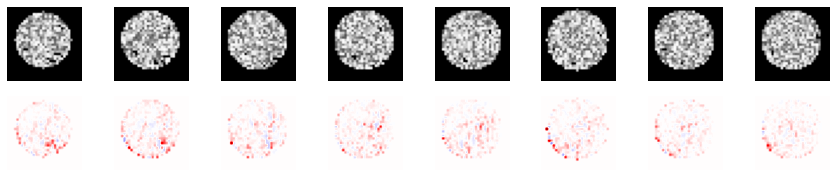

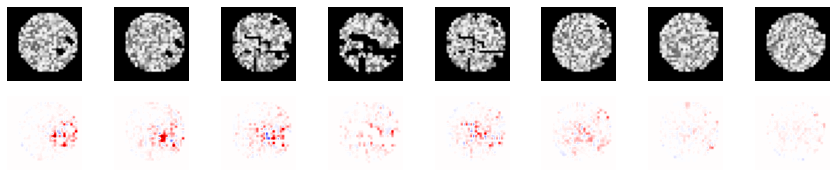

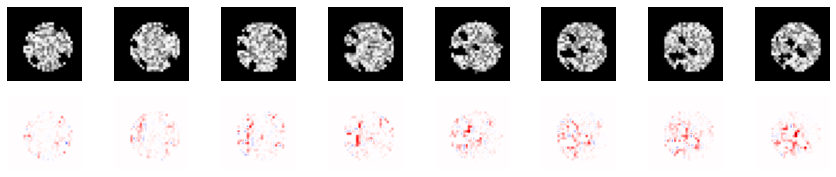

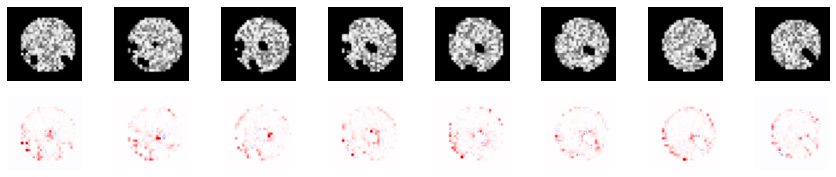

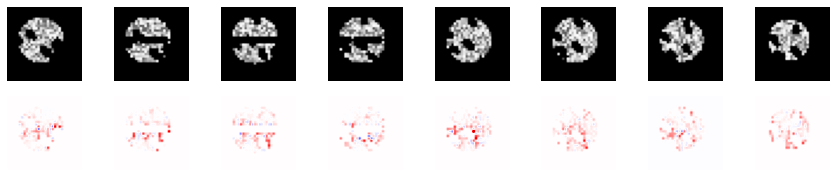

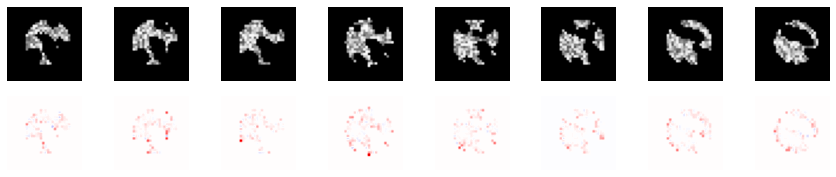

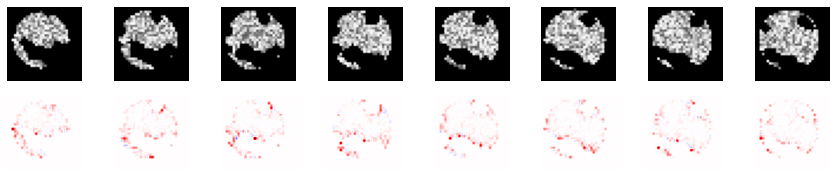

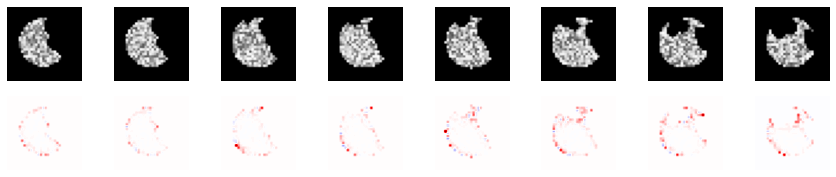

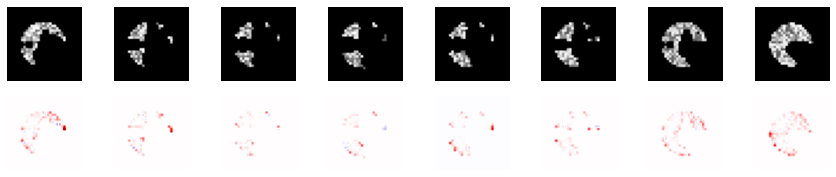

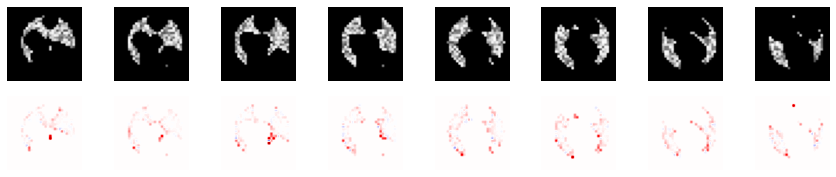

In [50]:
from explainability import LayerwiseRelevancePropagator

explainer = LayerwiseRelevancePropagator(model, layer=23, idx=0, alpha=2, beta=1)


for i in range(1, MAX_RADIUS + 1):
    fig, ax = plt.subplots(2, 8, figsize=(15, 3))
    idx = np.where(test_y == i)[0][0]
    explanations = explainer(test_X[idx:(idx + 1)])
    explanations = explanations / np.amax(np.abs(explanations))
    
    for j in range(8):
        ax[0][j].imshow(test_X[idx,12+j], cmap='Greys_r')
        ax[0][j].axis('off')
        ax[1][j].imshow(explanations[0,12+j], cmap='seismic', clim=(-1, 1))
        ax[1][j].axis('off')
        
plt.show()

In [33]:
print(len(model.layers))

23
